In [1]:
import torch
from tqdm import tqdm
from openstl.models.simvp_model import SimVP_Model
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
import torch.optim as optm
import os
from metrics import confusion_matrix, f1_score
import numpy as np
import torch.nn.functional as F
from torchsummary import summary

from BaseExperiment import _build_model

from osgeo import gdal

from pathlib import Path

from AmazonDataset import IbamaInpe25km_Dataset
from datetime import datetime

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_tif_image(tif_path):
    gdal_header = gdal.Open(str(tif_path))
    return gdal_header.ReadAsArray()

def normalize_non_temporal(data):
    '''Normalize the non-temporal channels'''
    data[data < -1e38] = -1
    _data = data[data != -1]
    mean = _data.mean(axis=0)
    std = _data.std(axis=0)
    print('Mean:', mean, 'Std:', std)
    return (data - mean) / std

In [28]:
batch_size = 32
custom_training_config = {
    'pre_seq_length': 2,
    'aft_seq_length': 1,
    'total_length': 3,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 100,
    'lr': 1e-4,
    # 'metrics': ['mse', 'mae', 'acc', 'Recall', 'Precision', 'f1_score', 'CM'],
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp09', # custom_exp
    'dataname': 'custom',
    'in_shape': [2, 1, 98, 136], # T, C, H, W = args.in_shape
    'patience': 10,
    'delta': 0.001,
}

custom_model_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py',
    
    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 2,
    'N_T': 2,
    'hid_S': 32, # default: 64
    'hid_T': 128 # default: 256
}

device = "cuda:0"
work_dir_path = os.path.join('work_dirs', custom_training_config['ex_name'])
model = _build_model(custom_training_config['in_shape'], None, custom_model_config, device)
model.load_state_dict(torch.load(os.path.join(work_dir_path, 'checkpoint.pth')))

32 128
[False, True]


<All keys matched successfully>

In [16]:
imgs_lst = ['data/IBAMA_INPE/25K/INPE/tiff/ArCS010720.tif', 'data/IBAMA_INPE/25K/INPE/tiff/ArCS160720.tif',
            'data/IBAMA_INPE/25K/INPE/tiff/ArCS010820.tif', 'data/IBAMA_INPE/25K/INPE/tiff/ArCS160820.tif']

In [17]:
root_dir = Path('/home/thiago/AmazonDeforestation_Prediction/OpenSTL/data/IBAMA_INPE/25K')
inpe_folder_path = root_dir / 'INPE/tiff'

# Hidrografia
hidr_files = load_tif_image(inpe_folder_path / 'hidr.tif')
hidr_files = normalize_non_temporal(hidr_files)
# Não Floresta (Ex: Banco de Areia)
no_for_files = load_tif_image(inpe_folder_path / 'nf.tif')
no_for_files = normalize_non_temporal(no_for_files)
# Categorias Fundiarias
rodnofic = load_tif_image(inpe_folder_path / 'rodnofic.tif')
rodofic = load_tif_image(inpe_folder_path / 'rodofic.tif')
disturb = load_tif_image(inpe_folder_path / 'distUrb.tif')
distrios = load_tif_image(inpe_folder_path / 'distrios.tif')
distport = load_tif_image(inpe_folder_path / 'distport.tif')
efams_apa = load_tif_image(inpe_folder_path / 'EFAMS_APA.tif')
efams_ass = load_tif_image(inpe_folder_path / 'EFAMS_ASS.tif')
efams_car = load_tif_image(inpe_folder_path / 'EFAMS_CAR.tif')
efams_fpnd = load_tif_image(inpe_folder_path / 'EFAMS_FPND.tif')
efams_ti = load_tif_image(inpe_folder_path / 'EFAMS_TI.tif')
efams_uc = load_tif_image(inpe_folder_path / 'EFAMS_UC.tif')

rodnofic = normalize_non_temporal(rodnofic)
rodofic = normalize_non_temporal(rodofic)
disturb = normalize_non_temporal(disturb)
distrios = normalize_non_temporal(distrios)
distport = normalize_non_temporal(distport)
efams_apa = normalize_non_temporal(efams_apa)
efams_ass = normalize_non_temporal(efams_ass)
efams_car = normalize_non_temporal(efams_car)
efams_fpnd = normalize_non_temporal(efams_fpnd)
efams_ti = normalize_non_temporal(efams_ti)
efams_uc = normalize_non_temporal(efams_uc)

Mean: 15.128107 Std: 48.94824
Mean: 38.883995 Std: 102.73632
Mean: 39434.92 Std: 50893.535
Mean: 93020.734 Std: 103628.414
Mean: 285372.72 Std: 209684.69
Mean: 8258.333 Std: 7290.846
Mean: 482264.06 Std: 275951.53
Mean: 0.038676128 Std: 0.16871342
Mean: 0.073253796 Std: 0.18637697
Mean: 0.16317934 Std: 0.2478483
Mean: 0.11018756 Std: 0.2341652
Mean: 0.25147587 Std: 0.39583778
Mean: 0.20884953 Std: 0.36096618


In [7]:
train_set = IbamaInpe25km_Dataset(root_dir=root_dir, Debug=False)

mean, mean_for, mean_clouds = train_set.mean, train_set.mean_for, train_set.mean_clouds
std, std_for, std_clouds = train_set.std, train_set.std_for, train_set.std_clouds

print()
print(mean, mean_for, mean_clouds)
print(std, std_for, std_clouds)

345
82
   date_str       date
0  20170801 2017-08-01
1  20170816 2017-08-16
2  20170901 2017-09-01
3  20170916 2017-09-16
4  20171001 2017-10-01
5  20171016 2017-10-16
6  20171101 2017-11-01
7  20171116 2017-11-16
8  20171201 2017-12-01
9  20171215 2017-12-15
   date_str       date
21   010817 2017-08-01
62   160817 2017-08-16
25   010917 2017-09-01
66   160917 2017-09-16
29   011017 2017-10-01
70   161017 2017-10-16
33   011117 2017-11-01
74   161117 2017-11-16
37   011217 2017-12-01
78   161217 2017-12-16
   date_str       date
21   010817 2017-08-01
62   160817 2017-08-16
25   010917 2017-09-01
66   160917 2017-09-16
29   011017 2017-10-01
70   161017 2017-10-16
33   011117 2017-11-01
74   161117 2017-11-16
37   011217 2017-12-01
78   161217 2017-12-16
Mean: 0.010244118 Std: 0.33525315
Mean: 435.46982 Std: 213.20291
Mean: 226.50984 Std: 259.5244
Mean: 15.128107 Std: 48.94824
Mean: 38.883995 Std: 102.73632
Mean: 39434.92 Std: 50893.535
Mean: 93020.734 Std: 103628.414
Mean: 285372.72 

In [29]:
filenames = imgs_lst[:-1]
for i, file in enumerate(filenames[:-1]):
    # print(file)
    file = file.split('/')[-1].split('.tif')[0][4:]
    print(file)
    img = load_tif_image(inpe_folder_path / ('ArCS' + file + '.tif'))
    img_flor = load_tif_image(inpe_folder_path / ('flor' + file + '.tif'))
    cloud_date = datetime.strptime(file, '%d%m%y').strftime('%Y%m%d')
    try:
        img_clouds = load_tif_image(inpe_folder_path / ('nv' + cloud_date + '.tif'))
    except:
        cloud_date = cloud_date.replace('16', '15')
        img_clouds = load_tif_image(inpe_folder_path / ('nv' + cloud_date + '.tif'))

    if i == 0:
        data = np.expand_dims(img, axis=0)
        data_flor = np.expand_dims(img_flor, axis=0)
        data_clouds = np.expand_dims(img_clouds, axis=0)
    else:
        data = np.concatenate((data, np.expand_dims(img, axis=0)), axis=0)
        data_flor = np.concatenate((data_flor, np.expand_dims(img_flor, axis=0)), axis=0)
        data_clouds = np.concatenate((data_clouds, np.expand_dims(img_clouds, axis=0)), axis=0)

data[data < -1e38] = 0
data_flor[data_flor < -1e38] = 0
data_clouds[data_clouds < -1e38] = 0

print(imgs_lst[-1])
labels = load_tif_image(imgs_lst[-1])
labels[labels < -1e38] = 0

data = data - mean / std
data_flor = data_flor - mean_for / std_for
data_clouds = data_clouds - mean_clouds / std_clouds

# data = np.stack((data, data_flor, data_clouds), axis=1)
catg_fundi = np.stack((rodnofic, rodofic, disturb, distrios, distport,\
    efams_apa, efams_ass, efams_car, efams_fpnd, efams_ti, efams_uc), axis=0)
catg_fundi = np.stack((catg_fundi, catg_fundi), axis=0)
# data = np.concatenate((data, catg_fundi), axis=1)
data = np.expand_dims(data, axis=1)

print(data.shape)

010720
160720
data/IBAMA_INPE/25K/INPE/tiff/ArCS160820.tif
(2, 1, 98, 136)


In [30]:
# mean = 0.00870167
# std = 0.30169973

# for img_name in imgs_lst:
# img1 = load_tif_image(imgs_lst[0])
# img2 = load_tif_image(imgs_lst[1])
# img = np.stack([img1, img2], axis=0)
# print(img.shape)
# img = torch.tensor(img).unsqueeze(1).to(device)
# print(img.shape)
# img[img < -1e38] = 0
# img_norm = (img - mean) / std
with torch.no_grad():
    pred = model(torch.tensor(data).to(device).unsqueeze(0))
    print(pred.shape)

torch.Size([1, 2, 1, 98, 136])


(1, 98, 136)
tensor(0.6359, device='cuda:0') tensor(-6.2048, device='cuda:0')
37.023422 -1.0


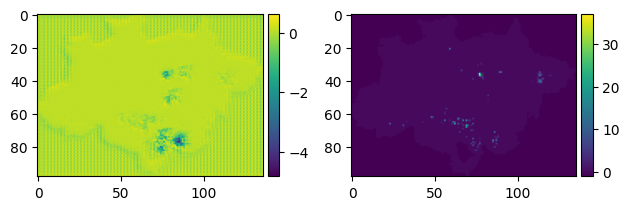

In [31]:
# Plot pred and img_lst[2] side by side
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2)
print(pred[0, 0].cpu().numpy().shape)
im1 = ax[0].imshow(pred[0, 0, 0].cpu().numpy())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax)
print(pred.max(), pred.min())

label = load_tif_image(imgs_lst[2])
print(label.max(), label.min())
# label[label < -1e38] = -1
im2 = ax[1].imshow(label)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax)
plt.tight_layout()
plt.show()

fig.savefig("figure_exp09.png", dpi=300)

In [70]:
test_data = train_set.get_test_set()
test_set = IbamaInpe25km_Dataset(root_dir=root_dir, Debug=False, mode='val', val_data=test_data, means=[train_set.mean, train_set.mean_for, train_set.mean_clouds], stds=[train_set.std, train_set.std_for, train_set.std_clouds])
    
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

preds = []
labels = []
model.eval()
with torch.no_grad():
    for inputs, label in tqdm(dataloader_test):
        y_pred = model(inputs.to(device))
        y_pred = y_pred[:, 0].contiguous().unsqueeze(1)
        preds.append(y_pred.cpu().numpy())
        labels.append(label.numpy())

Mean: 15.128107 Std: 48.94824
Mean: 38.883995 Std: 102.73632
Mean: 39434.92 Std: 50893.535
Mean: 93020.734 Std: 103628.414
Mean: 285372.72 Std: 209684.69
Mean: 8258.333 Std: 7290.846
Mean: 482264.06 Std: 275951.53
Mean: 0.038676128 Std: 0.16871342
Mean: 0.073253796 Std: 0.18637697
Mean: 0.16317934 Std: 0.2478483
Mean: 0.11018756 Std: 0.2341652
Mean: 0.25147587 Std: 0.39583778
Mean: 0.20884953 Std: 0.36096618


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


In [71]:
preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)

print(preds.shape, labels.shape)

(22, 1, 1, 98, 136) (22, 1, 1, 98, 136)


0.13471359 -0.26293394
(787,)


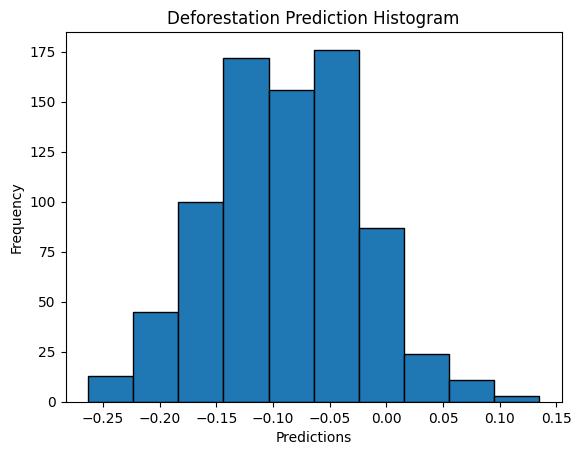

In [72]:
preds_def = preds[labels > 0]
print(preds_def.max(), preds_def.min())
print(preds_def.shape)

# Plotting the histogram
plt.hist(preds_def, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Deforestation Prediction Histogram')

# Display the plot
plt.show()

0.38630208 -0.425298
(292429,)


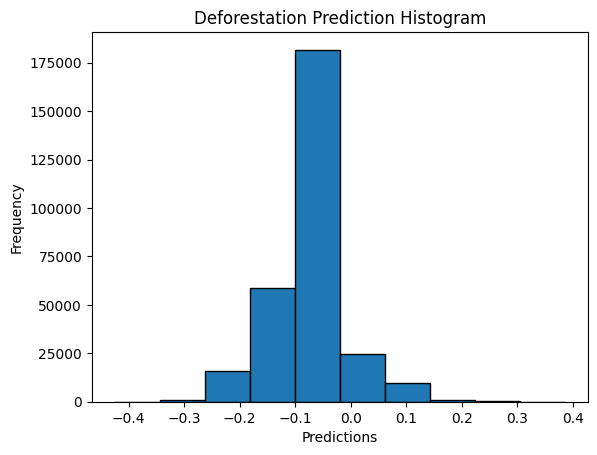

In [73]:
preds_no_def = preds[labels <= 0]
print(preds_no_def.max(), preds_no_def.min())
print(preds_no_def.shape)

# Plotting the histogram
plt.hist(preds_no_def, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Deforestation Prediction Histogram')

# Display the plot
plt.show()